In [26]:
# Import some of the basis required functions
import pandas as pd
import numpy as np
from scipy.stats import norm
from joblib import Parallel, delayed
import networkx as nx
from scipy.stats import norm
import scipy as sp
import matplotlib.pyplot as plt
import ffn 
from matplotlib import collections as matcoll


In [3]:
startprice = ffn.get('^GSPC:Close', start='2020-08-31',end='2020-08-31').values[0][0]

<h3>Monte Carlo Simulation</h3>

In [4]:
# Exercise 1: Monte Carlo Simulation
class MonteCarlo():
    def __init__(self,sigma = None, rf = None, K = 3300):
        # If we do not call the function with a value, 
        # initialize at the "standard" numbers
        if rf==None:
            self.rf = (1+0.005/4)**4 - 1
        else:
            self.rf = rf
        if sigma == None:
            self.sigma = np.sqrt(12)*0.0428156
        else:
            self.sigma = sigma
        self.K     = K
        self.S0    = startprice
        
    def propagate(self,Sn,dT):
        phis = np.random.randn(len(Sn))
        return Sn + Sn * (self.rf*dT + self.sigma*np.sqrt(dT)*phis)
            
    def payout(self,prices,T,M):
        payoff = prices - self.K
        return (np.exp(-1*self.rf * T) / M )* np.sum(payoff)
    
    def simulate(self,M,N,T):
        # Generate array of length M with values for phi
        dT = T/N
        prices = np.ones(M) * self.S0
        for i in range(N):
            prices = self.propagate(prices,dT)
        payout = self.payout(prices,T,M)
        return payout
    
    def stochastic_differential(self,M,T):
        phis = np.random.randn(M)
        prices = self.S0 * np.exp((self.rf - 0.5*self.sigma**2)*T
                                  +self.sigma*np.sqrt(T)*phis)
        return prices
    
    def stochastic_payout(self,M,T):
        prices = self.stochastic_differential(M,T)
        payoff = prices - self.K
        return (np.exp(-1*self.rf * T))* np.mean(payoff)
    
    def black_scholes(self,T,call_put='call'):   
        S = self.S0
        K = self.K
        sigma = self.sigma
        r = self.rf
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

        if call_put == 'call':
            optionprice = (S * norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * norm.cdf(d2, 0.0, 1.0))
        elif call_put == 'put':
            optionprice = (K * np.exp(-r * T) * norm.cdf(-d2, 0.0, 1.0) - S * norm.cdf(-d1, 0.0, 1.0))
        self.BSprice = optionprice
        
    def plot_convergence(self,M_arr,values,M_many,values_many):
        plt.figure()
        plt.scatter(M,values,color='red')
        plt.plot(M_many,values_many, color='black', label='Simulation',alpha=0.3)
        plt.ylabel('Option price at inception (USD)', size=13)
        plt.xlabel('Number of simulations', size=13)
        plt.axhline(self.BSprice, label='Black-Scholes limit',ls='dotted')
        plt.legend(loc='best', fontsize=12)
        plt.tight_layout()

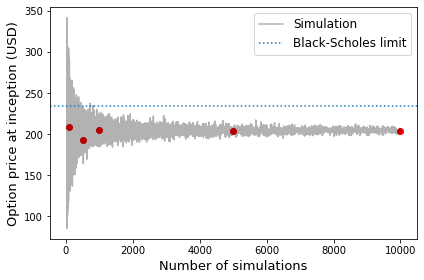

In [5]:
# Exercise a
MC = MonteCarlo()
M = np.array([100,500,1000,5000,10000])
call_values = [MC.simulate(w,3,0.25) for w in M]
M_many = np.logspace(1.5,4,10000,dtype=int)
call_values_many = Parallel(n_jobs=22)(delayed(MC.simulate)(N,3,0.25) for N in M_many)
MC.black_scholes(T=0.25)
MC.plot_convergence(M,call_values,M_many,call_values_many)

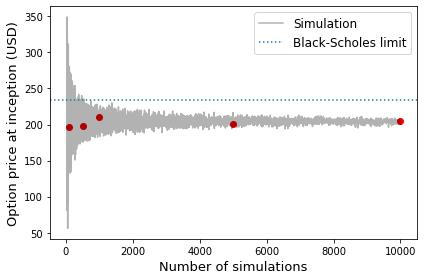

In [6]:
# Exercise b
MC = MonteCarlo()
M = np.array([100,500,1000,5000,10000])
call_values = [MC.simulate(w,63,0.25) for w in M]
M_many = np.logspace(1.5,4,10000,dtype=int)
call_values_many = Parallel(n_jobs=22)(delayed(MC.simulate)(N,63,0.25) for N in M_many)
MC.black_scholes(T=0.25)
MC.plot_convergence(M,call_values,M_many,call_values_many)

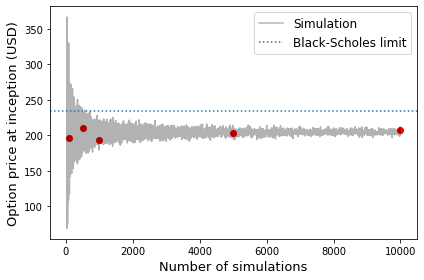

In [7]:
# Exercise c
MC = MonteCarlo()
M = np.array([100,500,1000,5000,10000])
call_values = [MC.stochastic_payout(w,0.25) for w in M]
M_many = np.logspace(1.5,4,10000,dtype=int)
call_values_many = Parallel(n_jobs=22)(delayed(MC.stochastic_payout)(N,0.25) for N in M_many)
MC.black_scholes(T=0.25)
MC.plot_convergence(M,call_values,M_many,call_values_many)

<h3>Dynamic Hedging</h3>

In [155]:
class DynamicHedging():
    def __init__(self,S0,K,T,r,sigma,mu):
            self.S0 = S0
            self.K  = K
            self.T  = T
            self.rf = r
            self.sigma = sigma
            self.mu = mu
            
    def black_scholes(self,S,T,call_put='call',ret_ds = False):   
        K = self.K
        sigma = self.sigma
        r = self.rf
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1-sigma*np.sqrt(T)

        if call_put == 'call':
            optionprice = (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
        elif call_put == 'put':
            optionprice = (K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1))
        self.BSprice = optionprice   
        return {'delta':norm.cdf(d1), 'optionprice':optionprice}
        
     
    def money_received(self,T,Ncontracts):
        self.black_scholes(self.S0,T)
        return 100*Ncontracts*self.BSprice
    
    def propagate(self,Sn,dT):
        phis = np.random.randn(len(Sn))
        return Sn + Sn * (self.mu*dT + self.sigma*np.sqrt(dT)*phis)
            
    #def payout(self,prices,T,M):
    #    payoff = prices - self.K
    #    return (np.exp(-1*self.rf * T) / M )* np.sum(payoff)
    
    def simulate_paths(self,M,N,T):
        # Generate array of length M with values for phi
        dT = T/N
        prices = np.ones((M,N)) * self.S0
        for i in range(N-1):
            prices[:,i+1] = self.propagate(prices[:,i],dT)
        return prices
    
    def plot_paths(self,M,N,T):
        prices = self.simulate_paths(M,N,T)
        weeks = np.arange(1,N+1)
        plt.figure()
        plt.plot(weeks,prices.T,color='black',lw=0.04)
        # Add label to one line, otherwise we need to remove 4999 legend markers
        plt.plot(weeks,prices[-1,:],color='black',lw=0.02,label='Simulations')
        plt.ylabel('Stock price (USD)', size=13)
        plt.xlabel('Number of weeks passed', size=13)
        plt.plot(weeks,prices.mean(axis=0),label='Trailing mean',color='red',ls='dotted')
        lgd = plt.legend(loc='best')
        for legobj in lgd.legendHandles:
            legobj.set_linewidth(1.0)
        plt.tight_layout()   
        plt.show()
        return prices
    
    def hedging(self,T, N):
        S = self.S0
        sigma = self.sigma
        strike = self.K
        rf = self.rf
        mu = self.mu

        # We start with zero cash
        cash = 0.0
        dt = T/N
        # We start with zero stock (delta)
        delta = 0.0
        # Get value and delta of BS call
        call = self.black_scholes(S,T)
        # We short a call and thus receive the BS call price
        cash = call['optionprice']
        for i in range(N):
            call = self.black_scholes(S,T)
            # Delta is how much we need to have form the stock to hedge
            # Subtract what we already have; what do we need to buy or sell
            ToBuySell = call['delta'] - delta    
            # Our cash position changes with what we buy / sell at price S
            cash -= ToBuySell*S
            # How much we own of the stock now
            delta = call['delta']
            print ( "Timestep", i+1, "Stock price:", S, "Delta:", delta)
            print ("Amount  for buying/selling" , ToBuySell)
            e = sp.random.normal(0,1)

            # Simulate stock price using mu and sigma
            S = S + S * (mu*dt + sigma*np.sqrt(dt)*e)
            # The time remaining decreases by dt
            print(S)
            T -= dt
            # We receive interest on the cash money
            cash *= np.exp(rf*dt)
        # Interest is not paid at the maturity of the option
        cash = cash / np.exp(rf*dt)                       
        return cash+delta*S-max(0,S-strike) # Get total profit or loss
    
    def hedging_distr(self,T,N,nsims = 10000):
        profit = np.array(Parallel(n_jobs=22)(delayed(self.hedging)(T,N) for iter_ in range(nsims)))
        plt.figure()

        plt.ylabel('Frequency', size=13)
        plt.xlabel('Profit (loss) (USD)', size=13)
        plt.hist(profit,bins=np.arange(-500,500,10))
plt.show()

In [156]:
# Get value at inception using BS result
startingprice = 3300
strike        = 3300
T             = 0.25
r             = np.log((1+0.005/4)**4)#-1
sigma         = np.exp(np.sqrt(12)*0.0428156)-1
mu            = 0.04

In [59]:
DH = DynamicHedging(startingprice,strike,T,r,sigma,mu)
print('Amount received is ',DH.money_received(T,10))

Amount received is  107221.62695149223


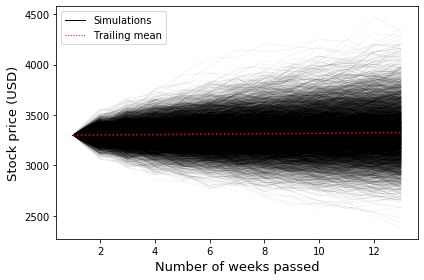

In [12]:
# Simulate paths for S&P
stockprices = DH.plot_paths(5000,13,13/52)

In [31]:
# Need dynamic hedging using d1 values from BS result
# At each of the 13 timesteps we need to evaluate the value for N(d1)

In [ ]:
DH.hedging_distr(0.25,3,100000)